# Transfer Learning: дообучение сети.

В этом ноутбуке мы загрузим предобученную на ImageNet сверточную сеть и дообучим ее на задачу классификации пород собак.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import os
import copy
import time
from PIL import Image
from tqdm import tqdm_notebook

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms

## Загрузка предобученной сети

Загружаем предобученный resnet из репозитория pytorch.

Вот еще [ссылка на туториал](https://pytorch.org/vision/main/models.html) PyTorch по предобученным моделям

In [ ]:
# модель resnet-18
model = models.resnet18(pretrained=True)
model

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 182MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Чтобы использовать предобученную сеть resnet18 наиболее эффективно, желательно все изображения, которые мы подаем ей на вход, предобрабатывать определенным образом — таким же, как обрабатывались изображения при первичном обучении resnet18. Для всех сетей семейства resnet в torchvision есть свои фиксированные преобразования.

При этом для решения новой задачи можно добавить к этому списку преобразований новые, исходя из ваших знаний о данных, которые вы используете.

Список преобразований, доступных в torchvision, [можно посмотреть тут](https://pytorch.org/vision/0.20/transforms.html).

In [ ]:
resnet_transforms = transforms.Compose([
        transforms.Resize(256), # размер каждой картинки будет приведен к 256*256
        transforms.CenterCrop(224), # у картинки будет вырезан центральный кусок размера 224*224
        transforms.ToTensor(), # картинка из питоновского массива переводится в формат torch.Tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # значения пикселей картинки нормализуются
    ])

# можно самому не писать преобразования, а просто взять их из models:
# resnet_transforms = models.ResNet18_Weights.IMAGENET1K_V1.transforms()

## Тест предобученной сети на одной картинке

Загрузим картинку песика из интернета:

In [ ]:
! wget "https://ichef.bbci.co.uk/news/640/cpsprodpb/475B/production/_98776281_gettyimages-521697453.jpg" -O "doggie.jpg"

--2025-02-15 16:54:56--  https://ichef.bbci.co.uk/news/640/cpsprodpb/475B/production/_98776281_gettyimages-521697453.jpg
Resolving ichef.bbci.co.uk (ichef.bbci.co.uk)... 96.7.156.164, 2600:1409:9800:688::f33, 2600:1409:9800:684::f33, ...
Connecting to ichef.bbci.co.uk (ichef.bbci.co.uk)|96.7.156.164|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23424 (23K) [image/jpeg]
Saving to: ‘doggie.jpg’

doggie.jpg          100%[===================>]  22.88K  --.-KB/s    in 0.006s  

2025-02-15 16:54:56 (3.70 MB/s) - ‘doggie.jpg’ saved [23424/23424]



Посмотрим на картинку:

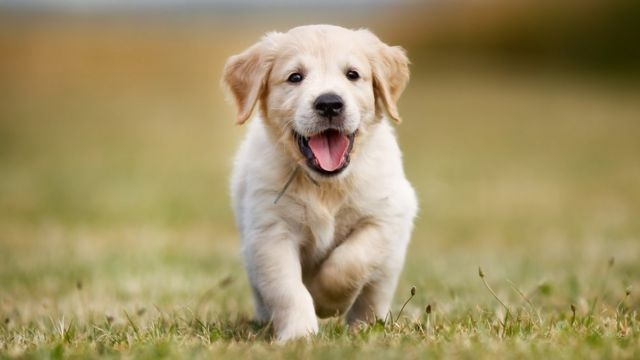

In [ ]:
from PIL import Image

image = Image.open('doggie.jpg')
image

Применим трансформации к картинке и посмотрим, как она будет после этого выглядеть:

In [ ]:
image_transformed = resnet_transforms(image)
print(image_transformed.shape)

torch.Size([3, 224, 224])


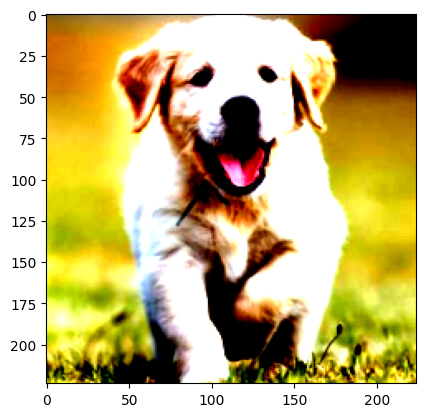

In [ ]:
plt.imshow(image_transformed.permute(1,2,0).data.cpu().numpy())

Подадим картинку на вход сети и получим ответ:

In [ ]:
model.eval()

# image_transformed -> [image_transformed]
model_output = model(image_transformed.reshape((1, 3, 224, 224)))
model_output

tensor([[ 7.7923e-01, -6.5713e-01, -2.0355e+00, -5.2771e+00, -1.6973e+00,
         -2.8970e-01, -2.7641e+00, -1.9297e+00, -5.7047e-01, -3.0571e+00,
         -2.2652e+00, -1.9824e+00, -1.5387e+00, -4.1534e+00, -8.4872e-01,
         -4.5245e+00, -4.1303e+00, -3.0133e+00, -4.0182e+00, -5.2528e+00,
         -2.1531e+00, -8.5778e-01, -1.3138e+00,  1.0640e-01,  1.4036e-01,
          2.6826e-01, -4.2953e-01, -6.8401e-01, -2.4271e-01, -1.9418e+00,
         -2.4971e+00, -3.3424e+00, -1.6081e+00, -1.0295e+00,  7.2670e-01,
          7.7685e-01,  1.1581e+00, -1.3271e+00, -1.7540e+00, -1.4787e+00,
         -1.4925e+00, -7.6697e-02, -8.1115e-01, -2.2953e+00, -3.3856e-02,
         -6.6323e-01, -1.0589e+00,  4.3270e-01, -9.9236e-01, -2.7333e+00,
         -1.1264e+00,  1.8996e-02,  2.0581e-01, -3.5283e-01, -2.3014e+00,
         -1.8041e+00, -4.0221e-01, -2.0437e+00, -1.6803e+00, -2.1154e+00,
         -1.7406e-01, -1.1477e+00, -2.0555e+00,  2.9124e-01,  5.4842e-01,
         -2.9602e+00, -1.9082e+00, -1.

Получим ответ сети на картинку. Соотношения номеров классов и названий можно посмотреть тут: https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a

In [ ]:
np.argmax(model_output.data.cpu().numpy())

207

## Дообучение сети на новом датасете

Мы будем обучать нейросеть на датасете пород собак. Ссылка: https://www.kaggle.com/datasets/gpiosenka/70-dog-breedsimage-data-set

Вы можете скачать датасет на google colab с помощью двух ячеек ниже или же загрузить датасет на свой гугл диск и подмонтировать его с помощью google.colab.drive.

**Внимание**: если пользуетесь этим методом скачивания данных, не забудьте поменять пути к папкам train, val и test при создании датасетов ниже.

In [ ]:
# эта ячейка скачивает zip архив с данными
! wget "https://www.dropbox.com/s/r11z0ugf2mezxvi/dogs.zip?dl=0" -O dogs.zip

--2025-02-15 16:59:13--  https://www.dropbox.com/s/r11z0ugf2mezxvi/dogs.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/cgwxt4jlpesmb9oq9s19f/dogs.zip?rlkey=ysuiqksb7i8ewm117m5e7lqxh&dl=0 [following]
--2025-02-15 16:59:13--  https://www.dropbox.com/scl/fi/cgwxt4jlpesmb9oq9s19f/dogs.zip?rlkey=ysuiqksb7i8ewm117m5e7lqxh&dl=0
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc78fbc93cd71245db03418e7946.dl.dropboxusercontent.com/cd/0/inline/CkIrEAEGHizuNQ7RRmJzRJfgMbba9JQWEVDXoxygVi-dSjelLuypBzxg7dg6q4H66kGIE8DNsaaHV4PRYecdpWKzU2rEV7sKTfnShtzFNpoY7-zNwbHzdLbMibSrILwWttuH4GO122bzZrwpETULknJg/file# [following]
--2025-02-15 16:59:14--  https://uc78fbc93cd71245db03418e7946.dl.dropboxusercontent.com/cd/0/inlin

In [ ]:
# эта ячейка распаковывает архив. В колабе появится папка ./dogs с данными.
! unzip -qq dogs.zip

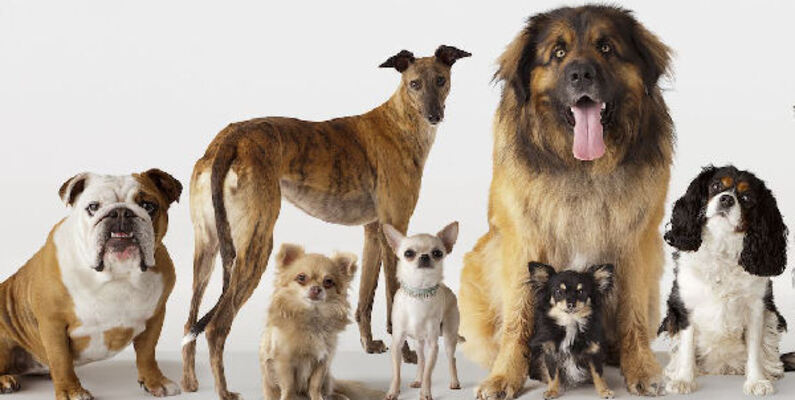

Заведем датасеты и даталоадеры.

Для того, чтобы из папки с картинками сделать PyTorch Dataset, можно воспользоваться datasets.ImageFolder. Для этого папка с картинками должна иметь следующий вид:


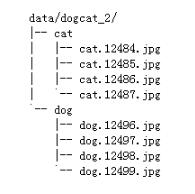


То есть, внутри папки с данными должны быть N подпапок, где N — количество классов в датасете. Каждая подпапка соответствует одному классу картинок. Название папки — название класс. Внутри папки с названием класса находятся картинки, принадлежащие этому классу.

In [ ]:
resnet_transforms = transforms.Compose([
        transforms.Resize(256), # размер каждой картинки будет приведен к 256*256
        transforms.CenterCrop(224), # у картинки будет вырезан центральный кусок размера 224*224
        transforms.ToTensor(), # картинка из питоновского массива переводится в формат torch.Tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # значения пикселей картинки нормализуются
    ])

In [ ]:
train_data = datasets.ImageFolder('./dogs/train/', transform=resnet_transforms)
val_data = datasets.ImageFolder('./dogs/valid/', transform=resnet_transforms)
test_data = datasets.ImageFolder('./dogs/test/', transform=resnet_transforms)

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

### Заморозка весов и замена последнего слоя

In [ ]:
model = models.resnet18(pretrained=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Заменим последний слой сети на новый, содержащий 70 нейронов (так как у нас 70 классов в датасете):

In [ ]:
model.fc

Linear(in_features=512, out_features=1000, bias=True)

In [ ]:
model.fc = nn.Linear(512, 70)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Заморозим все сверточные слои:

In [ ]:
len(list(model.children()))

10

In [ ]:
list(model.children())[5]

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-

In [ ]:
for i, layer in enumerate(model.children()):
  if i < 9:
    for param in layer.parameters():
      param.requires_grad = False

Напишем функцию, которая совершает все описанные шаги, чтобы было удобно переопределять сеть:

In [ ]:
def define_net():
    model = models.resnet18(pretrained=True)
    model.fc = nn.Linear(512, 70)
    for i, layer in enumerate(model.children()):
        if i < 9:
            for param in layer.parameters():
                param.requires_grad = False
    return model

model = define_net()

Перенесем нашу нейросеть на GPU, если GPU доступен:

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
model = model.to(device)

### Обучение сети

In [ ]:
# выбираем функцию потерь
loss_fn = torch.nn.CrossEntropyLoss()

# выбираем алгоритм оптимизации и learning_rate
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Функция обучения сети:

In [ ]:
from IPython.display import clear_output
from sklearn.metrics import accuracy_score

def evaluate(model, dataloader, loss_fn=None, name='test'):

    y_pred_list = []
    y_true_list = []

    losses = []

    for i, batch in enumerate(dataloader):

        # так получаем текущий батч
        X_batch, y_batch = batch

        with torch.no_grad():
            logits = model(X_batch.to(device))

            if loss_fn is not None:
                loss = loss_fn(logits, y_batch.to(device))
                losses.append(loss.item())

            y_pred = torch.argmax(logits, dim=1)

        y_pred_list.extend(y_pred.cpu().numpy())
        y_true_list.extend(y_batch.numpy())


    accuracy = accuracy_score(y_pred_list, y_true_list)

    return accuracy, np.mean(losses)

def train(model, loss_fn, optimizer, n_epoch=3):

    train_losses = []
    train_accuracies = []

    val_losses = []
    val_accuracies = []

    # цикл обучения сети
    for epoch in range(n_epoch):

        model.train(True)

        for i, batch in enumerate(train_loader):
            # так получаем текущий батч
            X_batch, y_batch = batch

            # forward pass (получение ответов на батч картинок)
            logits = model(X_batch.to(device))

            # вычисление лосса от выданных сетью ответов и правильных ответов на батч
            loss = loss_fn(logits, y_batch.to(device))

            loss.backward() # backpropagation (вычисление градиентов)
            optimizer.step() # обновление весов сети
            optimizer.zero_grad() # обнуляем веса

            # выведем лосс на график раз в 50 итераций обучения
            if i % 50 == 0:

                fig, axes = plt.subplots(2, 2, figsize=(14, 10))

                train_losses.append(loss.item())

                # вычислим accuracy на текущем train батче
                model_answers = torch.argmax(logits, dim=1)
                train_accuracy = accuracy_score(y_batch.numpy(), model_answers.cpu().numpy())
                train_accuracies.append(train_accuracy)

                train_iterations = np.array(range(len(train_losses)))*50

                # отрисовываем train_losses
                axes[0, 0].plot(train_iterations, train_losses)
                axes[0, 0].set_title('Train losses')
                axes[0, 0].set(xlabel='Iterations', ylabel='Loss')

                # отрисовываем train_accuracies
                axes[0, 1].plot(train_iterations, train_accuracies)
                axes[0, 1].set_title('Train accuracies')
                axes[0, 1].set(xlabel='Iterations', ylabel='Accuracy')

                val_iterations = np.array(range(len(val_losses)))*50

                axes[1, 0].plot(val_iterations, val_losses)
                axes[1, 0].set_title('Val losses')
                axes[1, 0].set(xlabel='Iterations', ylabel='Loss')

                axes[1, 1].plot(val_iterations, val_accuracies)
                axes[1, 1].set_title('Val accuracies')
                axes[1, 1].set(xlabel='Iterations', ylabel='Accuracy')

                plt.show()

                clear_output(wait=True)

        # после каждой эпохи получаем метрику качества на валидационной выборке
        model.train(False)

        val_accuracy, val_loss = evaluate(model, val_loader, loss_fn=loss_fn, name='val')
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

    return model, train_losses, val_losses, val_accuracies

Обучаем сеть:

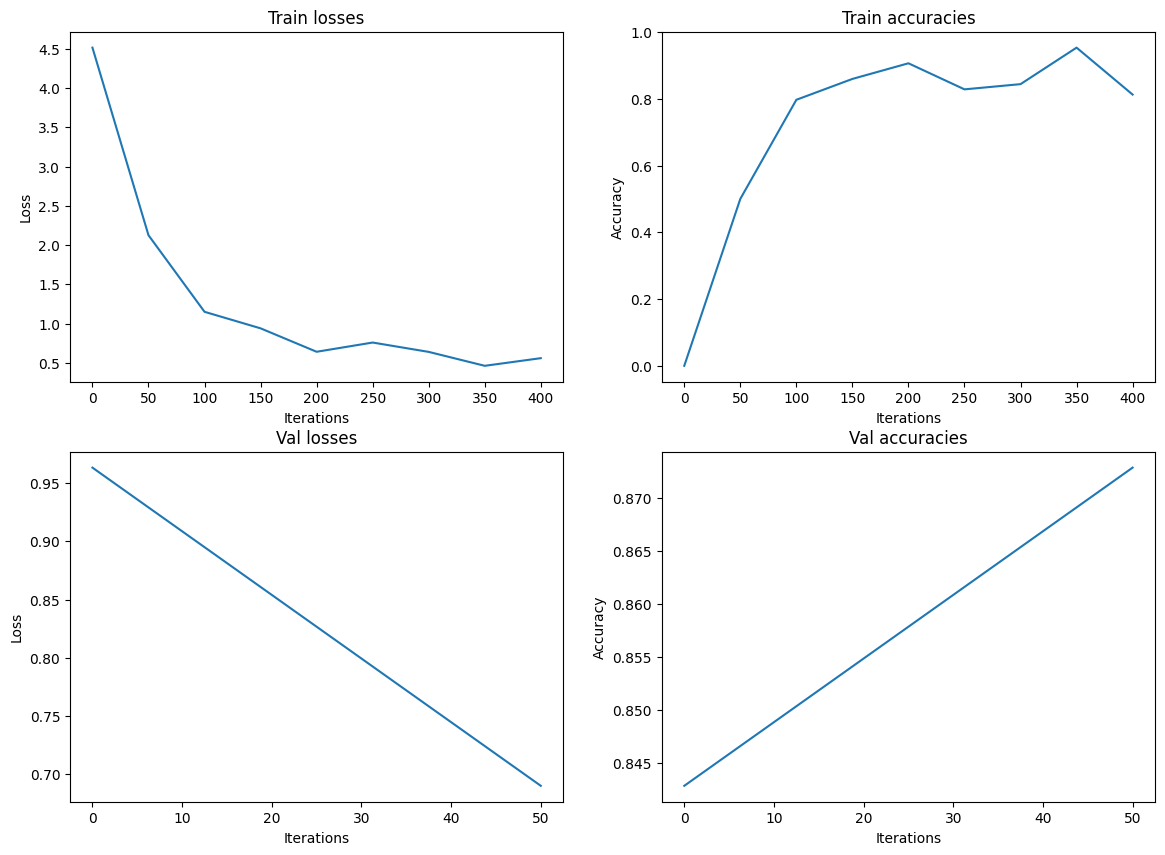

In [ ]:
model, train_losses, val_losses, val_accuracies = train(model, loss_fn, optimizer, n_epoch=3)

Проверим метрику accuracy на тренировочной и тестовой выборках:

In [ ]:
train_accuracy, _ = evaluate(model, train_loader);
print('Train accuracy is', train_accuracy)

Train accuracy is 0.9132897055122075


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
val_accuracy, _ = evaluate(model, val_loader);
print('Val accuracy is', val_accuracy)

Val accuracy is 0.8971428571428571


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
test_accuracy, _ = evaluate(model, test_loader);
print('Test accuracy is', test_accuracy)

Test accuracy is 0.9414285714285714


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


## Сохранение модели

Сохранение модели:

In [ ]:
torch.save(model, 'model_dogs.pt')

Загрузка модели из сохраненного чекпоинта:

In [ ]:
model_new = torch.load('model_dogs.pt')

<ipython-input-32-bbfa7a15c356>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_new = torch.load('model_dogs.pt')


Проверим, что модель загрузилась и что она точно та же, что мы тестировали выше:

In [ ]:
test_accuracy, _ = evaluate(model_new, test_loader, name='test');
print('Test accuracy is', test_accuracy)

Test accuracy is 0.9414285714285714


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Загруженную модель можно, например, дообучить еще несколько эпох:

In [ ]:
model_new, train_losses, val_losses, val_accuracies = train(model_new, n_epoch=5)